<body>
    <h1>RAG System for Kendrick Lamar</h1>
    <img src="https://bg-so-1.zippyimage.com/2024/05/21/c31c6d86f84bce7b319185204954e2ce.jpg" alt="Kendrick Lamar" width="500px">
    <p>Leveraging Llama3 and FAISS to Build a Kendrick Lamar-General Knowledge RAG System</p>
</body>

# NLP Project - 2024

**Author:** Pietro Girotto

**ID:** 2088245

**Course of Study:** Computer Engineering

In [1]:
!pip install -q langchain==0.2.0 torch==2.3.0 faiss-cpu==1.8.0 \
transformers==4.40.2 sentence_transformers==2.7.0 \
gdown==5.1.0 huggingface_hub==0.20.3 accelerate==0.30.1 bitsandbytes==0.43.1 \
langchain_community==0.2.0 langchainhub==0.1.15 xformers==0.0.26.post1 \
nltk==3.8.1 matplotlib==3.7.1 numpy==1.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/315.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
%matplotlib inline

The following libraries were used for the project:
* langchain: This is the core of the project, used to exploit built-in classes for dataset chunking, LLM chains and templatings.
* faiss-cpu: Used for creating the vector store. The CPU version to alleviate burden on the GPU, given the CPU results were extremly fast to retrieve
* transformers: Needed for loading ML models, in this case Llama 3
* sentence_transformers: Used for the embeddings model in the vector store
* gdown: Useful way for download gdrive files, making the notebook available to run for everyone to see
* accelerate, bits_and_bytes: Needed for LLM quantization and faster inference
* nltk, matplotlib, numpy: Used for a brief statistical analysis of the presented dataset.

## Constants

In [3]:
EMBEDDINGS_MODEL="sentence-transformers/all-MiniLM-L6-v2"
CHATBOT_MODEL="meta-llama/Meta-Llama-3-8B-Instruct"

In this project I choose the `all-MiniLM-L6-v2` embedding model in combination with `FAISS` for creating the vector store.
This decision was made because of the followings:
1. [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) is a paragraph embedder specifically suited for dimensionality reduction, dense vectors and semantic search. Others were used before hand, but higher dimensionality ultimately lead to sparsity and unrelated results to the query. Therefore I decided to stick to a lower-dims one.
2. [FAISS](https://github.com/facebookresearch/faiss) is one of the most used vector stores in the current business, as well one of the most robust. It might have been a little bit overkill for such a small dataset but gaining confidence with it was also a side quest.

When it comes to the LLM used, simply put [Llama 3](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/#meta-llama-3-instruct) is the SotA model for open source coding. Given it was recently released it was a great occasion to use it. Unfortunately, just the 8B parameters model fitted in the GPU so I went specifically with this one.

## Imports

In [4]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain import hub
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from torch import cuda, bfloat16
from transformers import AutoTokenizer
from huggingface_hub import login as hugging_login
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import transformers
import torch
import numpy as np
import nltk
import multiprocessing as mp
import time

## Preparing the dataset

The dataset was extracted from the [Wikipedia Dumps](https://dumps.wikimedia.org/) through the usage of a published library called [wikiextractor](https://github.com/attardi/wikiextractor). After downloading and parsing the dataset, it was then filtered to include all documents which were referring to Kendrick Lamar and then parsed into a suitable format to fit the langchain documents loaders.

For further info on how it was done, please see the `README.md` file.

In [5]:
!gdown 1ultVrIiYTZrglzLSUCn8krl0ae0Kje-s -O extract_kendrick.tar.gz
!tar -xzf extract_kendrick.tar.gz
!gdown 1HQLzX6GyPAG6Y23ORO6oSxW_kU6SLzUZ -O faiss_index.tar.gz
!tar -xzf faiss_index.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1ultVrIiYTZrglzLSUCn8krl0ae0Kje-s
To: /content/extract_kendrick.tar.gz
100% 4.88M/4.88M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HQLzX6GyPAG6Y23ORO6oSxW_kU6SLzUZ
To: /content/faiss_index.tar.gz
100% 22.0M/22.0M [00:00<00:00, 214MB/s]


In [6]:
"""
As creating the FAISS index can take some time, it has been already downloaded
and upacked to avoid spending time. Still by changing the variable to True
you can force the creation.
"""
CREATE_INDEX = False # @param {type: "raw"} ["False", "True"]

In [7]:
# Loading the dataset could be avoided if the CREATE_INDEX flag were to be set
# to false. However, we still need to make the Dataset Analysis
embedding_func = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)
loader = DirectoryLoader(
    path="extract_kendrick",
    glob="*.txt",
    use_multithreading=True,
    loader_cls=TextLoader
)

data = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=20
)
docs = text_splitter.split_documents(data)

if CREATE_INDEX:
    db = FAISS.from_documents(docs, embedding_func)
else:
    db = FAISS.load_local("faiss_build", embeddings=embedding_func, allow_dangerous_deserialization=True)

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Test query
query = "What day was born Kendrick Lamar?"
ans_docs = db.similarity_search_with_score(query, k=3)
ans_docs = sorted(ans_docs, key=lambda x: x[1], reverse=True) # Ordering by score
for doc, score in ans_docs:
    print(f"[{score}]: {doc.page_content}")

[0.8599497675895691]: Lamar began planning his second album before "Section.80" was released. From February to April 2012, he opened for Drake on his Club Paradise Tour. He began working with J. Cole on a collaborative album around that time, but nothing came to fruition; Cole later admitted that the two "put it to bed years ago". On March 8, "The Fader" reported that Lamar had signed a joint venture recording contract with Aftermath Entertainment and Interscope Records; under the deal, TDE continued to serve as his primary label. His first commercial single, "The Recipe" featuring Dr. Dre, premiered on rhythmic crossover radio on April 2.
"Good Kid, M.A.A.D City", Lamar's second album, was formally announced on June 26, 2012, with a tentative release date of October 2. Its lead single, "Swimming Pools (Drank)", peaked at number 17 on the "Billboard" Hot 100, marking his first top 20 single in the U.S. From September to October, he headlined the BET Music Matters Tour with Black Hippy 

Even though the query didn't go as well as expected (notice how the actual answer is only the third one) we still got the results we wanted, the setup is working and the documents that were retrieved are related to the question.

**Success!**

## Dataset Analysis

In [ ]:
# Download necessary NLTK tokenizer
nltk.download('punkt')

# Helper functions
def get_document_lengths(documents):
    return [len(word_tokenize(doc.page_content)) for doc in documents]

def get_sentence_counts(documents):
    return [len(sent_tokenize(doc.page_content)) for doc in documents]

def get_average_sentence_length(documents):
    total_sentences = sum(get_sentence_counts(documents))
    total_words = sum(get_document_lengths(documents))
    return total_words / total_sentences if total_sentences else 0

def get_average_document_length(documents):
    return np.mean(get_document_lengths(documents))

def plot_histogram(data, title, xlabel, ylabel, bins=20):
    plt.hist(data, bins=bins, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Raw and split document lengths
raw_document_lengths = get_document_lengths(data)
split_document_lengths = get_document_lengths(docs)

# Average sentence length
avg_sentence_length_raw = get_average_sentence_length(data)
avg_sentence_length_split = get_average_sentence_length(docs)

# Average document length
avg_document_length_raw = get_average_document_length(data)
avg_document_length_split = get_average_document_length(docs)

print(f"Average Sentence Length (Raw Documents): {avg_sentence_length_raw}")
print(f"Average Sentence Length (Split Documents): {avg_sentence_length_split}")
print(f"Average Document Length (Raw Documents): {avg_document_length_raw}")
print(f"Average Document Length (Split Documents): {avg_document_length_split}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Average Sentence Length (Raw Documents): 24.150021728879068
Average Sentence Length (Split Documents): 23.58760481684635
Average Document Length (Raw Documents): 2211.5571549534293
Average Document Length (Split Documents): 224.56362545018007


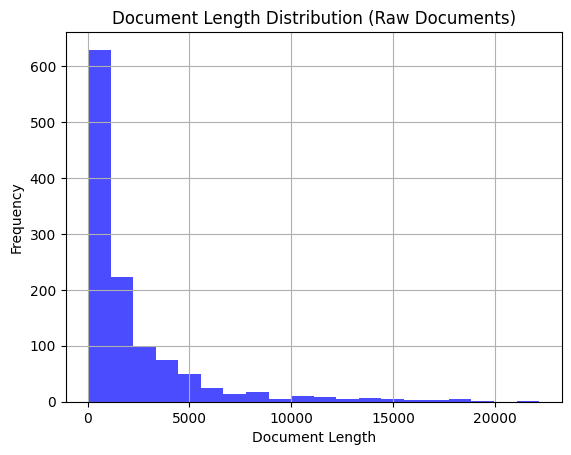

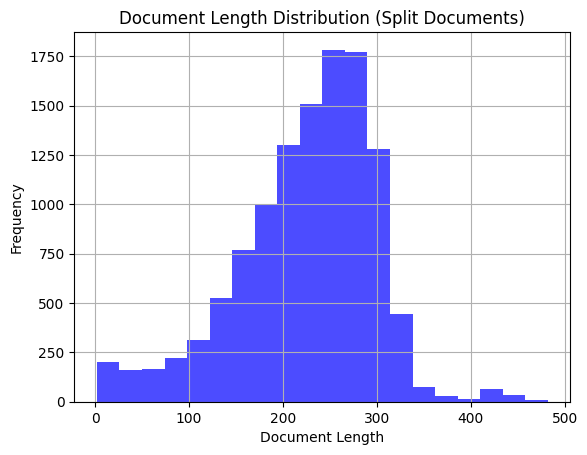

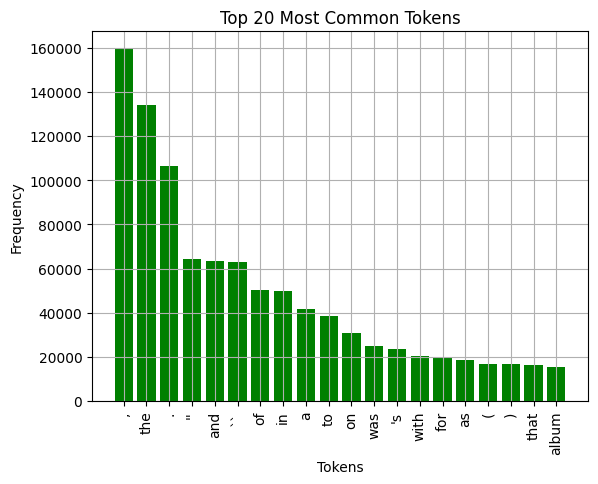

In [ ]:
# Plotting histograms
plot_histogram(raw_document_lengths, 'Document Length Distribution (Raw Documents)', 'Document Length', 'Frequency')
plot_histogram(split_document_lengths, 'Document Length Distribution (Split Documents)', 'Document Length', 'Frequency')

# Word frequency distribution (top 20 words)
all_tokens = [word.lower() for doc in data for word in word_tokenize(doc.page_content)]
common_tokens = Counter(all_tokens).most_common(20)
tokens, counts = zip(*common_tokens)

plt.bar(tokens, counts, color='green')
plt.title('Top 20 Most Common Tokens')
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the analysis we can see that, as expected, the average length for splitted and raw documents is respectively 140 and 2211 tokens. This is also reflected in the length distribution in the two plotted histograms.

Interestingly, we have a skewed distribution towards shorter texts in the raw documents.

However, the average number of words per sentence in both the raw and splitted documents is very similar, indicating that the RecursiveCharacterTextSplitter did a great job of not fragmenting sentences.

When it comes to the top 20 tokens most of the important ones are very trivial and common tokens in the English language. The only topic-related appereance is "album" which indicates a music-related dataset.

## Setting up LLama-3

In [8]:
hugging_login()

In [9]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

"""
    Even though for a 8B model there was no imperative need to quantize it
    (as it fits into the T4 GPU memory without compression) it was still done
    simply to gain confidence and experience with the technique.
"""
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    CHATBOT_MODEL,
    trust_remote_code=True,
    max_new_tokens=1024,
    do_sample=False
)

llm_model = transformers.AutoModelForCausalLM.from_pretrained(
    CHATBOT_MODEL,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(CHATBOT_MODEL)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Setting up the LLM pipeline

The template was obtained through a mixture of two things:
* [official Meta docs for prompting](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/#meta-llama-3-instruct): For the main structure that was used to train the model, to obtain maximum results
* [nvidia Llama3 QA finetune](https://huggingface.co/nvidia/Llama3-ChatQA-1.5-8B): For the system prompt which was clear and coincise.

Still there was a trial and error process to correctly identify and address the user prompt structure so that the output would be as polished as possible.
Some examples were:
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>


This is a chat between a user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions based on the context.
The assistant should also indicate when the answer cannot be found in the context.
Please refrain from referring the context in the answer and do not parse the question itself.<|eot_id|><|start_header_id|>user<|end_header_id|>


Consider this context: {context}\n\nAnswer this question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
```
But this one made the model implicitly referring the context, without actually including it. The answers were complete and correct though.

I tried then to explicitly tell the model to avoid wandering around and referring the context:
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>


This is a chat between a user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions based on the context.
The assistant should also indicate when the answer cannot be found in the context.
Do not refer to the context, just answer the questions.<|eot_id|><|start_header_id|>user<|end_header_id|>


Consider this context: {context}\n\nAnswer this question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
```
But this led to the model sometimes not giving all of the answers if prompted with several questions.

Finally, the prompt shown below was a great choice as the model doesn't refer to the context as implicitly as before but still with great detail and completeness.

In [10]:
template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

This is a chat between a user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions based on the context.
The assistant should also indicate when the answer cannot be found in the context.<|eot_id|><|start_header_id|>user<|end_header_id|>

Consider this context:\n{context}\n\nAnswer this question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
prompt_gen = PromptTemplate.from_template(template)

In [11]:
def generate_ans(question, prompt_gen, retriever, llm_model):
    relevant_docs = retriever.invoke(question)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    prompt = prompt_gen.format(question=question, context=context)
    tokenized = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    llm_model.eval()
    output_ids = llm_model.generate(input_ids=input_ids, attention_mask=attention_mask, temperature=0.1)
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    question_pattern = f"Answer this question: {question}assistant"
    index = output_text.find(question_pattern)

    if index == -1:
        return "Sorry there was an error in generating the answer"
    else:
        return output_text[index+len(question_pattern):]

In [12]:
%%time
out = generate_ans("Who is Kendrick Lamar?", prompt_gen, retriever, llm_model)

print(out)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




Kendrick Lamar Duckworth, also known as Kendrick Lamar, is an American rapper, singer-songwriter, and record producer. He was born on June 17, 1987, in Compton, California, to African American parents from the South Side of Chicago. He grew up in a challenging environment, experiencing homelessness and poverty, but found solace in hip-hop music. Lamar's early life and experiences have heavily influenced his music, which often addresses themes of social justice, racism, and personal growth. He has released several critically acclaimed albums, including "Good Kid, M.A.A.D City" and "To Pimp a Butterfly," and has won numerous awards, including multiple Grammy Awards.
CPU times: user 21.5 s, sys: 2.98 s, total: 24.5 s
Wall time: 29.2 s


Perfect! The main idea works, time to polish it.

Now moving to LangChain's pipelines structure and making the code more efficient and Object Oriented...

In [13]:
class AnswerGenerator(object):
    def __init__(self, retriever, llm_model, tokenizer, full_answer=False):
        template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

This is a chat between a user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions based on the context.
The assistant should also indicate when the answer cannot be found in the context.
Do not refer to the context in your answer.<|eot_id|><|start_header_id|>user<|end_header_id|>

Consider this context:\n{context}\n\nAnswer this question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

        no_rag_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

This is a chat between a user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions<|eot_id|><|start_header_id|>user<|end_header_id|>

{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
        self.no_rag_prompt_gen = PromptTemplate.from_template(no_rag_template)
        self.prompt_gen = PromptTemplate.from_template(template)
        self.retriever = retriever
        self.llm_model = llm_model
        self.tokenizer = tokenizer
        self.full_answer = full_answer

        self.pipeline = {
            "context": RunnableLambda(self._get_context),
            "question": RunnablePassthrough()
        } | RunnableLambda(self._get_prompt) | RunnableLambda(self._gen_answer)

    def _get_context(self, question):
        relevant_docs = self.retriever.invoke(question)
        context = "\n".join([doc.page_content for doc in relevant_docs])
        return context

    def _get_prompt(self, inputs):
        question = inputs["question"]
        context = inputs["context"]
        return self.prompt_gen.format(question=question, context=context)

    def _gen_answer(self, prompt):
        self.llm_model.eval()
        tokenized = self.tokenizer(prompt, return_tensors="pt").to(device)
        input_ids = tokenized['input_ids']
        attention_mask = tokenized['attention_mask']
        output_ids = llm_model.generate(input_ids=input_ids, attention_mask=attention_mask, temperature=0.1, pad_token_id=tokenizer.eos_token_id)
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        if self.full_answer:
            return output_text
        else:
            question_pattern = f"{self.question}assistant"
            index = output_text.find(question_pattern)

            if index == -1:
                return "Sorry there was an error in generating the answer"
            else:
                return output_text[index+len(question_pattern):]

    def __call__(self, question, with_rag=True):
        self.question = question
        if with_rag:
            return self.pipeline.invoke(question)
        else:
            prompt = self.no_rag_prompt_gen.format(question=question)
            self.question = question
            return self._gen_answer(prompt)


In [14]:
ans_gen = AnswerGenerator(retriever, llm_model, tokenizer, False)
question = "What are some of the best Lamar's songs?"

start = time.time()
answer = ans_gen(question)
end = time.time()

print(f"[{end-start:.2f} sec]\nQuestion: {question}\nAnswer: {answer}")

[19.81 sec]
Question: What are some of the best Lamar's songs?
Answer: 

I'd be happy to help you with that! Based on the context, it seems that Kendrick Lamar has had a wide range of critically acclaimed songs throughout his career. Some of his notable songs include:

* "Humble" (2017)
* "Like That" (2024, featuring Future and Metro Boomin)
* "Freedom" (2016, featuring Beyoncé)
* "Goosebumps" (2016, featuring Travis Scott)
* "Bad Blood" (2015, remix with Taylor Swift)

These songs have received widespread critical acclaim and have been successful on the charts. However, it's worth noting that Kendrick Lamar has a vast discography, and opinions on his best songs may vary depending on personal taste.


In [15]:
question = "Tell some interesting facts about Kendrick."
print("#"*26)
print(f"--- Question: {question}")
print(f"--- No RAG, only model:\n{ans_gen(question, with_rag=False)}")
print(f"--- With RAG: {question}\nAnswer: {ans_gen(question)}")
print("#"*26+"\n\n")

question = "Did Lamar set any record or achieved widely known prizes?"
print("#"*26)
print(f"--- Question: {question}")
print(f"--- No RAG, only model:\n{ans_gen(question, with_rag=False)}")
print(f"--- With RAG: {question}\nAnswer: {ans_gen(question)}")
print("#"*26+"\n\n")

question = "Could you please tell me more about Money Trees?"
print("#"*26)
print(f"--- Question: {question}")
print(f"--- No RAG, only model:\n{ans_gen(question, with_rag=False)}")
print(f"--- With RAG: {question}\nAnswer: {ans_gen(question)}")
print("#"*26+"\n\n")

##########################
--- Question: Tell some interesting facts about Kendrick.
--- No RAG, only model:


Kendrick Lamar is a highly acclaimed American rapper, songwriter, and record producer. Here are some interesting facts about him:

1. **Early Start**: Kendrick Lamar was born on June 17, 1987, in Compton, California. He started rapping at the age of 8 and was already writing his own rhymes by the time he was 11.

2. **Gangsta Grillz**: Kendrick's debut album, "Section.80", was released in 2011 and was a critical success. The album's lead single, "HiiiPoWeR", was featured on the popular mixtape series "Gangsta Grillz" hosted by DJ Skee.

3. **Good Kid, M.A.A.D City**: His second studio album, "Good Kid, M.A.A.D City", released in 2012, received widespread critical acclaim and is often cited as one of the best hip-hop albums of the 2010s.

4. **To Pimp a Butterfly**: Kendrick's third studio album, "To Pimp a Butterfly", released in 2015, was a commercial and critical success. Th

## Discussion

**Results**

As we can clearly see from the last sequence of answers the RAG setup has clearly accomplished 3 main things:
- precision: The facts about Kendrick told by the RAG setup are far more rap-related and culture-focused than the broad ones reported by the plain model.
- no ambiguity: In both the two last questions, the no RAG setup failed to grasp the true intentions of the questions by answering with information unrelated to the topic of the rapper. This is clearly solved and optimized in the RAG system even though the question is the same.
- Answer's coinciseness: The RAG setup is far more coincise, precise and does not prompt the user to further question as the less-instructued NO RAG setup. Take for example the end of the firs answer with NO RAG: `"Is there anything else you'd like to know about Kendrick Lamar?"`.

**Issues encountered**:

From time to time the model wouldn't generate any answer seemingly out of nowhere.
This behavious was not easy to investigate as it would randomly pop up, seemingly out of nowhere.
After carefully revisioning the code, I noticed that the prompts were enclosed by triple quotes string including also a final new line after the `<|start_header_id|>assistant<|end_header_id|>` line. Probably the model from time to time thought it was his new line, which most of the times can be associated with generating the `<EOS>` token.

**Future work**

This project is clearly a proof of concept, and as such could be improved in many ways:
1. Add templates to the extraction for the wikipedia datasets. This will greatly enhance the completeness of the data.
2. Use the 70B parameters version of LLama 3.

## Ackownledgement

This work was based on publicly available code. In particular to:
* [RAG with Llama 3](https://github.com/GURPREETKAURJETHRA/RAG-using-Llama3-Langchain-and-ChromaDB/blob/main/rag-using-llama3-langchain-and-chromadb.ipynb): Used only for settting up the bits_and_bytes configuration on Llama3. The rest of the notebook, despite the name, was not meeting my expectations and was using procedures I was not keen on reproducing.
* [Langchain main docs](https://python.langchain.com): Useful for debugging and understanding the main logic of many components.